In [132]:
from elements.batteryModel import LithiumIonBattery, make_OCVfromSOCtemp, make_dOCVfromSOCtemp
from elements.estimator import SPKF
from elements.plots import plot_SOC
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mat4py import loadmat
from scipy.linalg import block_diag, cholesky
from copy import copy

In [102]:
data = loadmat('./PANdata_P25.mat')
time    = np.array(data['DYNData']['script1']['time'])  
deltat = time[1]-time[0]
time    = time-time[0] # start time at 0
currents = np.array(data['DYNData']['script1']['current']) # discharge > 0; charge < 0.
voltages = np.array(data['DYNData']['script1']['voltage'])
soc     = np.array(data['DYNData']['script1']['soc'])

In [103]:
k = 999
ik = currents[k]
vk = voltages[k]
ik, vk

(12.49389302923675, 3.96522855758667)

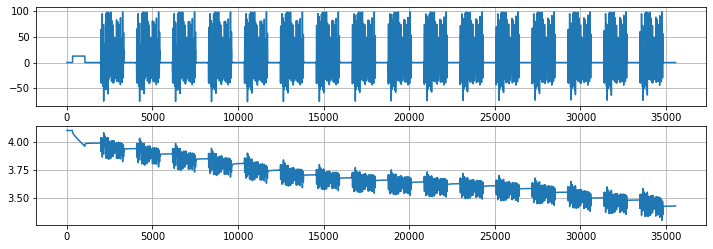

In [104]:
plt.figure(figsize=(12,4))
plt.subplot(2,1,1)
plt.plot(time,currents)
plt.grid()
plt.subplot(2,1,2)
plt.plot(time,voltages)
plt.grid()
plt.show()

In [105]:
deltat

1.0

In [106]:
LIB1 = LithiumIonBattery('models/PANmodel.mat', T=25, dt=deltat)


In [107]:
model = copy(LIB1)
ir0   = 0                        
hk0   = 0                        
SOC0  = 1 # self.model.OCVfromSOC(self.model.outputEqn(ir0))

xhat  = np.vstack([ir0,hk0,SOC0]) # initial state

# Covariance values
SigmaX = block_diag(1e2,1e-2,1e-3)  # uncertainty of initial state
SigmaV = 3e-1  # Uncertainty of voltage sensor, output equation
SigmaW = 4e0   # Uncertainty of current sensor, state equation

# SPKF specific parameters
Nx = SigmaX.shape[0]
Nw = 1
Nv = 1
Na = Nx+Nw+Nv
Wmx = np.zeros(2*Na+1)
h = np.sqrt(3)
Wmx[0] = (h**2-Na)/(h**2)
Wmx[1:] = 1/(2*h**2) 
Wcx=Wmx
Wm = Wmx.reshape(-1,1) # mean
Wc = Wcx.reshape(-1,1) # covar
Qbump = 5

# previous value of current
priorI = 10
model.sik

0

In [108]:
eigval, _ = np.linalg.eig(SigmaX)
# print(eigval)
sigmaXa = block_diag(SigmaX, SigmaW, SigmaV)
sigmaXa = np.real(cholesky(sigmaXa, lower=True))
xhata = np.vstack([xhat, np.zeros((Nw+Nv,1))])

In [109]:
Xa = xhata.reshape(Na,1) + h*np.hstack([np.zeros((Na, 1)), sigmaXa, -sigmaXa])
Xa[:,-1]

array([ 0.       ,  0.       ,  1.       ,  0.       , -0.9486833])

In [110]:
current = priorI
xnoise= Xa[Nx:Nx+Nw,:]
oldState=Xa[:Nx,:]

In [111]:
if oldState is not None: 
    (iR_k, h_k, z_k) = oldState
    z_k =  z_k.reshape(1,-1)
    iR_k = iR_k.reshape(1,-1)
    h_k =  h_k.reshape(1,-1)
else:
    z_k =  self.z_k.reshape(1,-1)
    iR_k = self.iR_k.reshape(1,-1)
    h_k =  self.h_k.reshape(1,-1)

h_k

array([[ 0.        ,  0.        ,  0.17320508,  0.        ,  0.        ,
         0.        ,  0.        , -0.17320508,  0.        ,  0.        ,
         0.        ]])

In [112]:
prisik = LIB1.sik
if abs(current)>LIB1.QParam/100: LIB1.sik = np.sign(current)

current = current + xnoise

eta = np.where(current<0, LIB1.etaParam, 1) #self.etaParam if current<0 else 1
Ah = np.exp(-abs(eta*current*LIB1.GParam*LIB1.dt/(3600*LIB1.QParam)))  # hysteresis factor
Arc = np.diag(np.exp(-LIB1.dt/abs(LIB1.RCParam)))
Brc = 1-(np.exp(-LIB1.dt/abs(LIB1.RCParam)))

z_k1 = z_k - (eta*LIB1.dt/(3600*LIB1.QParam))*current
iR_k1 = Arc@iR_k + Brc*current
h_k1 = Ah*h_k - (1-Ah)*np.sign(current)
z_k1 = np.clip(z_k1, -0.05, 1.05)
h_k1 = np.clip(h_k1, -1, 1)

# if abs(current)>self.QParam/100: self.sik = np.sign(current)
# LIB1.sik = np.where(abs(current)>LIB1.QParam/100, np.sign(current), prisik)
newState = (iR_k1, h_k1, z_k1)

In [113]:
h_k1

array([[-0.01808234, -0.01808234,  0.15199079, -0.01808234, -0.02426969,
        -0.01808234, -0.01808234, -0.18815546, -0.01808234, -0.01185575,
        -0.01808234]])

In [114]:
Xx = np.vstack(newState)
xhat = Xx@Wm
xhat

array([[ 2.39239063],
       [-0.0180758 ],
       [ 0.99911158]])

In [115]:
SigmaX = (Xx - xhat)@np.diag(Wm.ravel())@(Xx - xhat).T
SigmaX

array([[ 5.81046616e+01, -1.71467189e-03, -1.06841788e-05],
       [-1.71467189e-03,  9.65446522e-03,  8.50993857e-08],
       [-1.06841788e-05,  8.50993857e-08,  9.17926666e-04]])

In [116]:
current = ik
ynoise=Xa[Nx+Nw:,:]
state = Xx

if state is not None: 
    (iR_k, h_k, z_k) = state
    z_k =  z_k.reshape(1,-1)
    iR_k = iR_k.reshape(1,-1)
    h_k =  h_k.reshape(1,-1)

In [117]:
yy = LIB1.OCVfromSOC(z_k) + LIB1.MParam*h_k + LIB1.M0Param*LIB1.sik - LIB1.RParam*iR_k - LIB1.R0Param*current + ynoise
yy

array([[4.08441096, 4.08068422, 4.0859758 , 4.16390692, 4.08405829,
        5.03309426, 4.0881377 , 4.08284613, 4.01813487, 4.084764  ,
        3.13572766]])

In [118]:
yhat = yy@Wc
yhat

array([[4.08661433]])

In [119]:
SigmaXY = (Xx - xhat)@np.diag(Wc.ravel())@(yy - yhat).T
SigmaXY

array([[-1.64662599e-02],
       [ 8.94276704e-05],
       [ 1.27067682e-03]])

In [120]:
SigmaY  = (yy - yhat)@np.diag(Wc.ravel())@(yy - yhat).T
SigmaY

array([[0.30178599]])

In [121]:
L = SigmaXY/SigmaY
L

array([[-0.05456271],
       [ 0.00029633],
       [ 0.00421052]])

In [122]:
r = vk - yhat  # residual.  Use to check for sensor errors...
xhat + L*r 


array([[ 2.39901377],
       [-0.01811177],
       [ 0.99860049]])

In [123]:
r = vk - yhat  # residual.  Use to check for sensor errors...
if r**2 > 100*SigmaY: L=0
# print(L, r, yhat, vk)
xhat = xhat + L*r 
xhat[1] = np.clip(xhat[1], -1, 1)
xhat[-1] = np.clip(xhat[-1], -0.05, 1.05)


In [125]:
xhat

array([[ 2.39901377],
       [-0.01811177],
       [ 0.99860049]])

In [126]:
SigmaX = SigmaX - L*SigmaY*L.T
SigmaX

array([[ 5.81037631e+01, -1.70979248e-03,  5.86473859e-05],
       [-1.70979248e-03,  9.65443872e-03, -2.91437871e-07],
       [ 5.86473859e-05, -2.91437871e-07,  9.12576452e-04]])

In [127]:
_,S,V = np.linalg.svd(SigmaX)
HH = V@np.diag(S)@V.T
SigmaX = (SigmaX + SigmaX.T + HH + HH.T)/4 # Help maintain robustness
SigmaX

array([[ 5.81037631e+01,  9.71491675e-10,  5.86190581e-05],
       [ 9.71491675e-10,  9.65443872e-03, -2.89712757e-07],
       [ 5.86190581e-05, -2.89712757e-07,  9.12576452e-04]])

In [128]:
3*np.sqrt(SigmaX[-1,-1])

0.09062664106093743